## Data processing

In [3]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import geomloss as gs

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

## The data processing steps for the steam cell dataset is the same as that in https://github.com/thashim/population-diffusions. 
FilePath = '../../'

file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']

table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(FilePath+filein, header=None))

matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

# Normalization
def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

# sort genes by Wasserstein distance between D0 and D7
qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat] 
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

wsub = w_order[0:100]

def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features) 
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array([0,1,2,3,4,5,6,7,8,9])

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 4000.1233
total residual 138.7959
Iteration 200:
fit residual 123.6643
total residual 31.8464
Iteration 400:
fit residual 21.7894
total residual 12.6115
Iteration 500:
fit residual 4.3442
total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2257.8358
total residual 58.2265
Iteration 200:
fit residual 56.8198
total residual 4.0447
Iteration 400:
fit residual 3.4777
total residual 0.6841
Iteration 500:
fit residual 0.3744
total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2925.3664
total residual 80.2657
Iteration 200:
fit residual 78.1148
total residual 6.1559
Iteration 400:
fit residual 5.1661
total residual 1.1917
Iteration 500:
fit residual 0.6183
total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
f

## Model setting

In [4]:
# multi-layer perceptron
class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.LeakyReLU()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            #nn.init.xavier_uniform_(m.weight)
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
            #nn.init.constant_(m.bias,0) 
 
        self.activation = activation 

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))
            #x = F.dropout(x,p=0.5)

        return self.linears[-1](x)

# The Euler-Maruyama (EM) discretization scheme
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.intensity = torch.tensor(intensity,device="cuda")
        self.mean = nn.Parameter(0.01*torch.ones(in_features))
        self.covHalf = nn.Parameter(0.08*torch.eye(in_features))
        self.diffusion = nn.Parameter(torch.ones(bd,10))
        self.in_features = in_features
        self.jump = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size) 
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,bd),device="cuda")@self.diffusion+\
                (pois*self.mean + pois**(0.5)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")@self.covHalf)*self.jump(state)
            PopulationPath[:,i,:] = state
        return PopulationPath


# training data
train_data = norm_imputed2

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
        
setup_seed(80)

a=gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

## Read the training results 

In [5]:
with open('TrainingResultGridSearch.out','r') as f:
    re = f.readlines()

result = []
for i in range(len(re)):
    if re[i].startswith("best_score"):
        value = float(re[i][12:].strip())
        if value < 3.0:
            par = re[i+1]
            par = par[18:].strip()
            result.append(eval(par))

In [6]:
len(result)

40

## Find the baseline model

In [7]:
setup_seed(80)
all = [] ## a[1] stores the wasserstein distance between a model with the the 1st model as the baseline  
for baseline in range(40):
    HyperParameter = result[baseline]
    intensity = HyperParameter['intensity']
    bd = HyperParameter['bd']
    ceng = HyperParameter['dim_hidden']
    kuan = HyperParameter['hidden_size']
    step_size = HyperParameter['step_size']
    beishu = HyperParameter['beishu']

    print("Baseline {0}".format(baseline))

    netG0 = JumpEulerForwardCuda(10,ceng,kuan,step_size).cuda()
    netG0.load_state_dict(torch.load('./hyperparameter40/Task'+str(baseline)+'.pt'))

    path0 = netG0(train0,train0.shape[0],int(3.5*beishu)) # samples at all the 36 steps

    if beishu==20:
        path0 = path0[:,[2*n for n in range(36)],:]
        
    error = [[] for _ in range(40)] ## error[i][j] is the Wasserstein distance between the ith model and the baseline at every step
    for task in range(40):
        HyperParameter = result[task]
        intensity = HyperParameter['intensity']
        bd = HyperParameter['bd']
        ceng = HyperParameter['dim_hidden']
        kuan = HyperParameter['hidden_size']
        step_size = HyperParameter['step_size']
        beishu = HyperParameter['beishu']

        print("Task {0}".format(task))

        netG = JumpEulerForwardCuda(10,ceng,kuan,step_size).cuda()
        netG.load_state_dict(torch.load('./hyperparameter40/Task'+str(task)+'.pt'))

        path = netG(train0,train0.shape[0],int(3.5*beishu))

        if beishu==20:
            path = path[:,[2*n for n in range(36)],:]
        
        
        for step in range(36):
            discre = (a(path[:,step,:],path0[:,step,:])).item()
            error[task].append(discre)
            
    all.append(error)

Baseline 0
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 1
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 2
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 3
Task 0
Task 1
Task 2
Task 

Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 26
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 27
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Task 23
Task 24
Task 25
Task 26
Task 27
Task 28
Task 29
Task 30
Task 31
Task 32
Task 33
Task 34
Task 35
Task 36
Task 37
Task 38
Task 39
Baseline 28
Task 0
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10
Task 11
Task 12
Task 13
Task 14
Task 15
Task 16
Task 17
Task 18
Task 19
Task 20
Task 21
Task 22
Ta

In [8]:
np.array(all).shape

(40, 40, 36)

In [9]:
## find the baseline with minimum variance and the worst model
W_dist = []
for i in range(40):
    base_i = np.mean(np.array(all[i])**2)
    W_dist.append(base_i.item())
    print(base_i)

print(W_dist.index(min(W_dist)))
print(W_dist.index(max(W_dist)))
## baseline 13
## worst 29

1.2911147264746317
1.2969180311223405
2.0670244299493588
1.321915411204738
1.2497644415258586
1.2465375246417547
1.2409551666985559
1.5627041629020721
1.3624981564519332
1.1598279942712681
1.2202198003016342
1.3846606625516964
1.4453007285689996
1.0722828285756196
1.3140096871399012
1.4965604839518778
1.1364260374214497
1.231409761349823
1.2099210116741876
1.7610913479514354
1.233857233558756
1.322340676582057
1.8394113660610936
1.1365786386710843
1.1223440781673373
1.3432756318759194
1.1769430992225751
1.1473197611326422
1.458764410841148
2.9385449162184196
1.3026339021183428
1.1188327180109623
1.3450067278015512
1.198787729543056
1.3008862078760497
1.2412095130293597
1.4523138564446059
1.1368806197544346
1.7517998812350823
1.159664103197407
13
29


In [10]:
baseline = 13
HyperParameter = result[baseline]
intensity = HyperParameter['intensity']
bd = HyperParameter['bd']
ceng = HyperParameter['dim_hidden']
kuan = HyperParameter['hidden_size']
step_size = HyperParameter['step_size']
beishu = HyperParameter['beishu']

netG0 = JumpEulerForwardCuda(10,ceng,kuan,step_size).cuda()
netG0.load_state_dict(torch.load('./hyperparameter40/Task'+str(baseline)+'.pt'))

path0 = netG0(train0,train0.shape[0],int(3.5*beishu))

if beishu==20:
    path0 = path0[:,[2*n for n in range(36)],:]
    
error0 = [0,(a(path[:,10,:],train2)).item(),(a(path[:,20,:],train4)).item(),(a(path[:,35,:],train7)).item()]
print(error0)

[0, 0.8184376358985901, 1.312814474105835, 0.9610141515731812]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.         0.3864259  0.59379564 0.68883545 0.71591102 0.71114339
 0.68130801 0.64904242 0.61291036 0.59192313 0.59540725 0.62163517
 0.67159972 0.74895935 0.83019441 0.90969108 0.9700108  1.01230073
 1.0453744  1.07673724 1.11504211 1.18245142 1.2596515  1.36422121
 1.45304324 1.512748   1.53617142 1.52829137 1.47790648 1.4117604
 1.32683697 1.23780294 1.16871026 1.10833128 1.06922135 1.05664658]


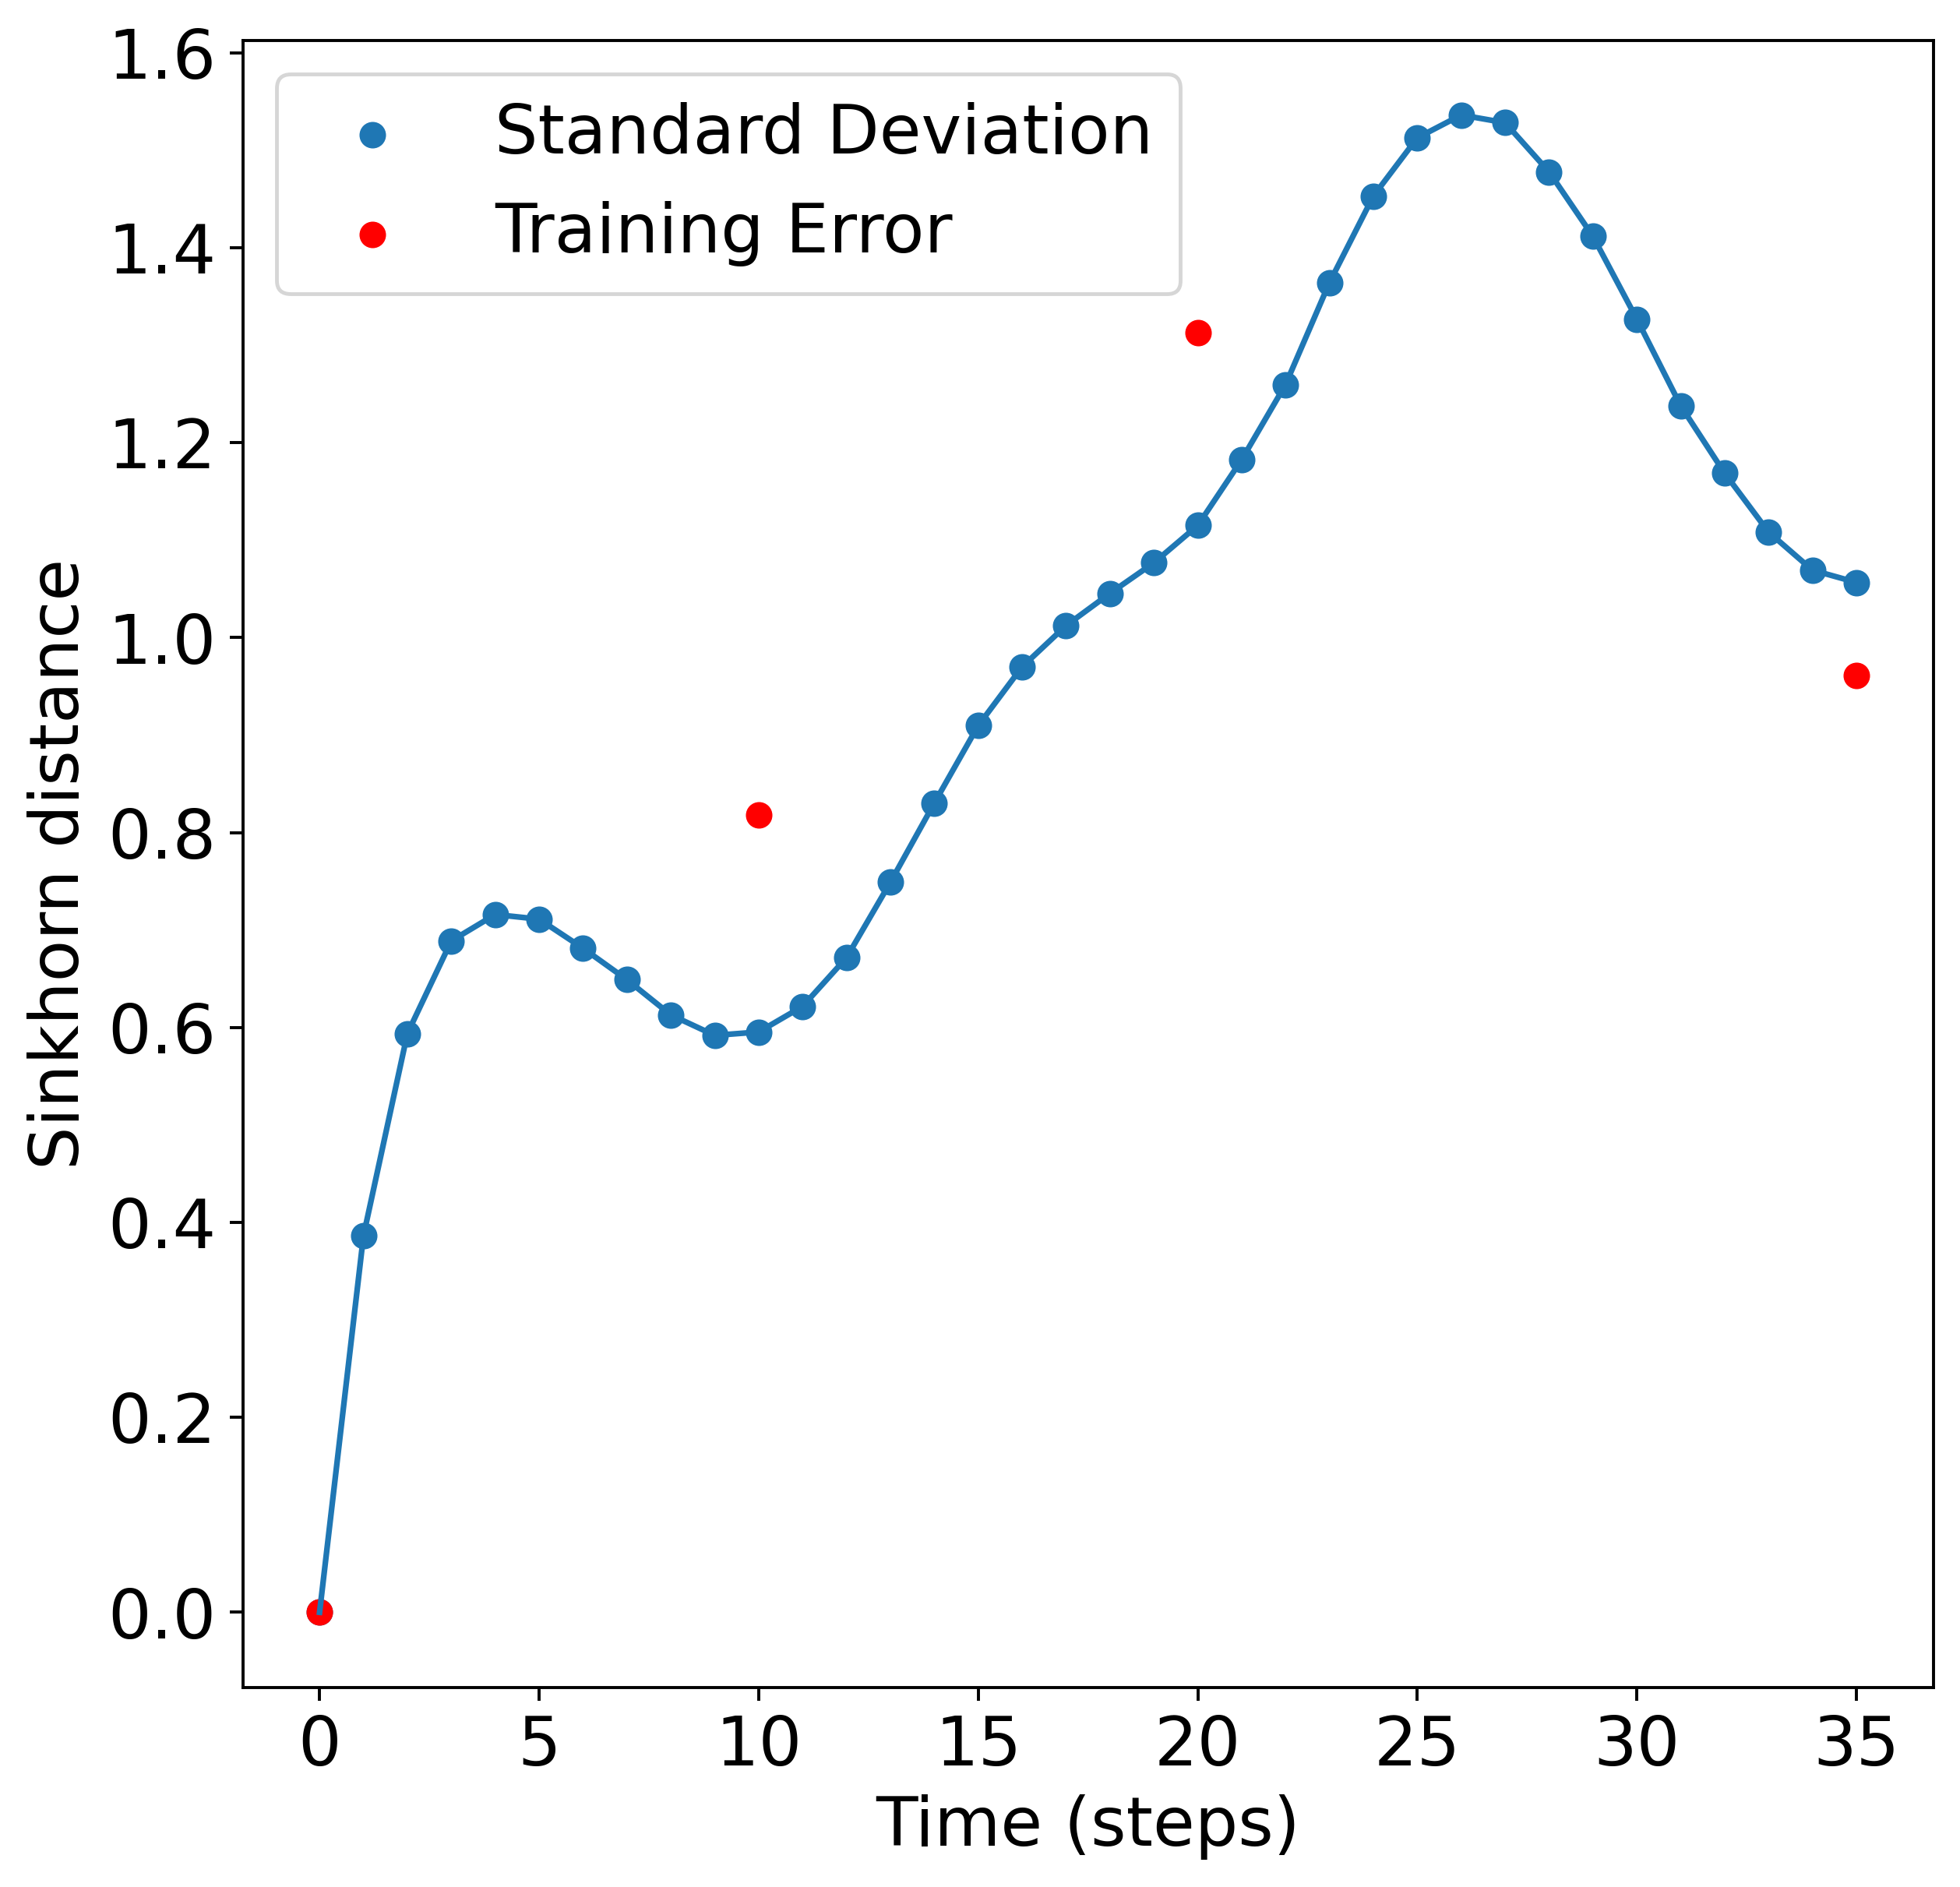

In [11]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8),dpi=350)

error = np.array(all[13])
cov = np.sum(error**2,axis=0)/40

print(cov**0.5)

plt.plot(np.linspace(0,35,num=36),cov**0.5)
plt.scatter(np.linspace(0,35,num=36),cov**0.5,label="Standard Deviation")

plt.scatter([0,10,20,35],error0,color="red",label="Training Error")

plt.xlabel("Time (steps)")
plt.ylabel("Sinkhorn distance")
    
plt.legend()

plt.savefig("./images/sd.eps",format="eps")

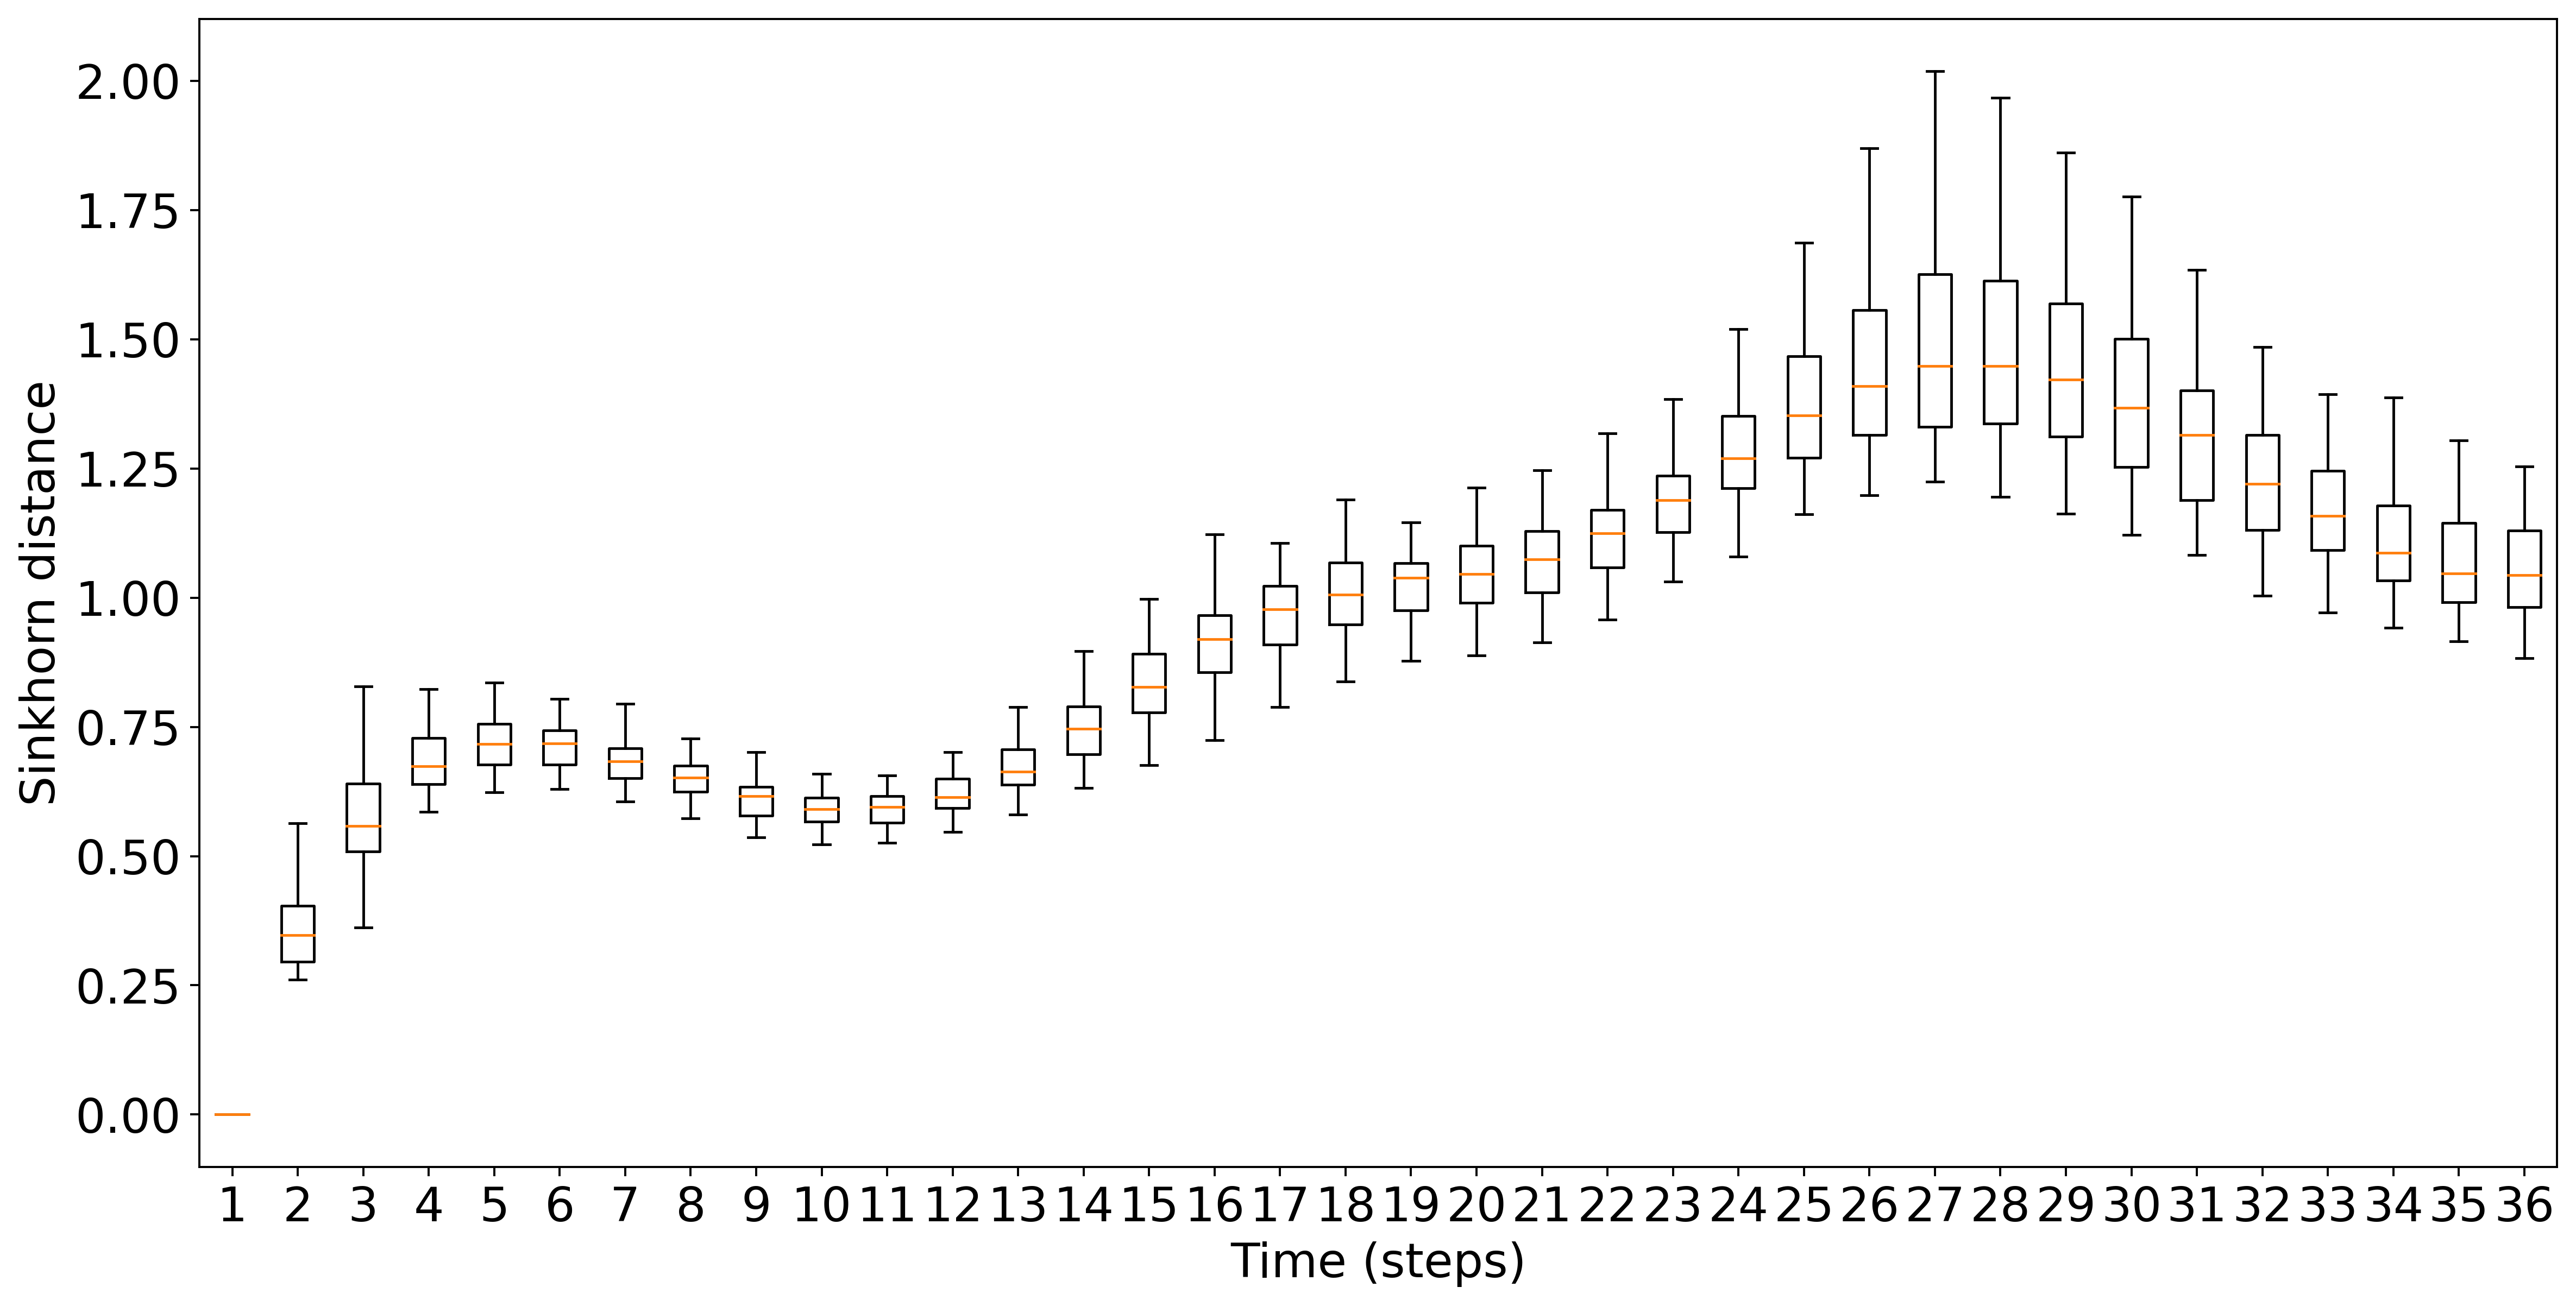

In [12]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16,8),dpi=350)

plt.xlabel("Time (steps)")
plt.ylabel("Sinkhorn distance")

plt.boxplot([[x[i] for x in error] for i in range(36)],showfliers=False)
plt.savefig("./images/box.eps",format="eps")

In [13]:
## parameter set
for i in range(40):
    print(i+1,result[i]['intensity'],result[i]['step_size'],result[i]['dim_hidden'],result[i]['hidden_size'],result[i]['beishu'],result[i]['bd'],result[i]['learning_rate'],result[i]['n_critic'])

1 30 0.05 4 128 10 3 0.0002 3
2 40 0.01 5 128 10 2 0.0003 3
3 190 0.01 5 128 10 3 0.0003 3
4 160 0.05 3 128 10 3 0.0003 5
5 50 0.01 5 256 10 4 0.0003 3
6 170 0.02 6 256 10 3 0.0002 3
7 80 0.03 6 256 10 4 0.0002 4
8 190 0.04 3 128 10 2 0.0003 5
9 200 0.03 3 256 20 2 0.0001 3
10 110 0.04 3 256 10 4 0.0002 4
11 80 0.01 6 256 20 2 0.0001 3
12 190 0.04 3 128 10 3 0.0003 4
13 80 0.05 4 128 20 2 0.0002 5
14 190 0.01 6 256 10 3 0.0001 3
15 140 0.03 4 256 20 3 0.0001 5
16 170 0.04 6 256 10 4 0.0002 3
17 90 0.02 4 256 10 2 0.0001 3
18 160 0.05 5 256 10 3 0.0001 4
19 70 0.05 3 256 10 2 0.0003 3
20 160 0.05 4 256 10 4 0.0002 3
21 170 0.03 6 256 20 2 5e-05 3
22 60 0.04 4 128 10 3 0.0003 3
23 170 0.02 5 128 10 3 0.0003 5
24 30 0.03 5 256 20 4 0.0002 5
25 50 0.01 6 256 10 4 0.0002 5
26 170 0.03 6 256 20 2 5e-05 3
27 30 0.04 4 256 10 4 0.0003 5
28 70 0.03 5 256 20 2 0.0003 5
29 100 0.01 5 256 20 3 0.0003 3
30 130 0.02 6 128 10 3 0.0003 4
31 10 0.03 4 256 10 2 0.0003 3
32 70 0.04 3 256 10 3 0.0002 5
33

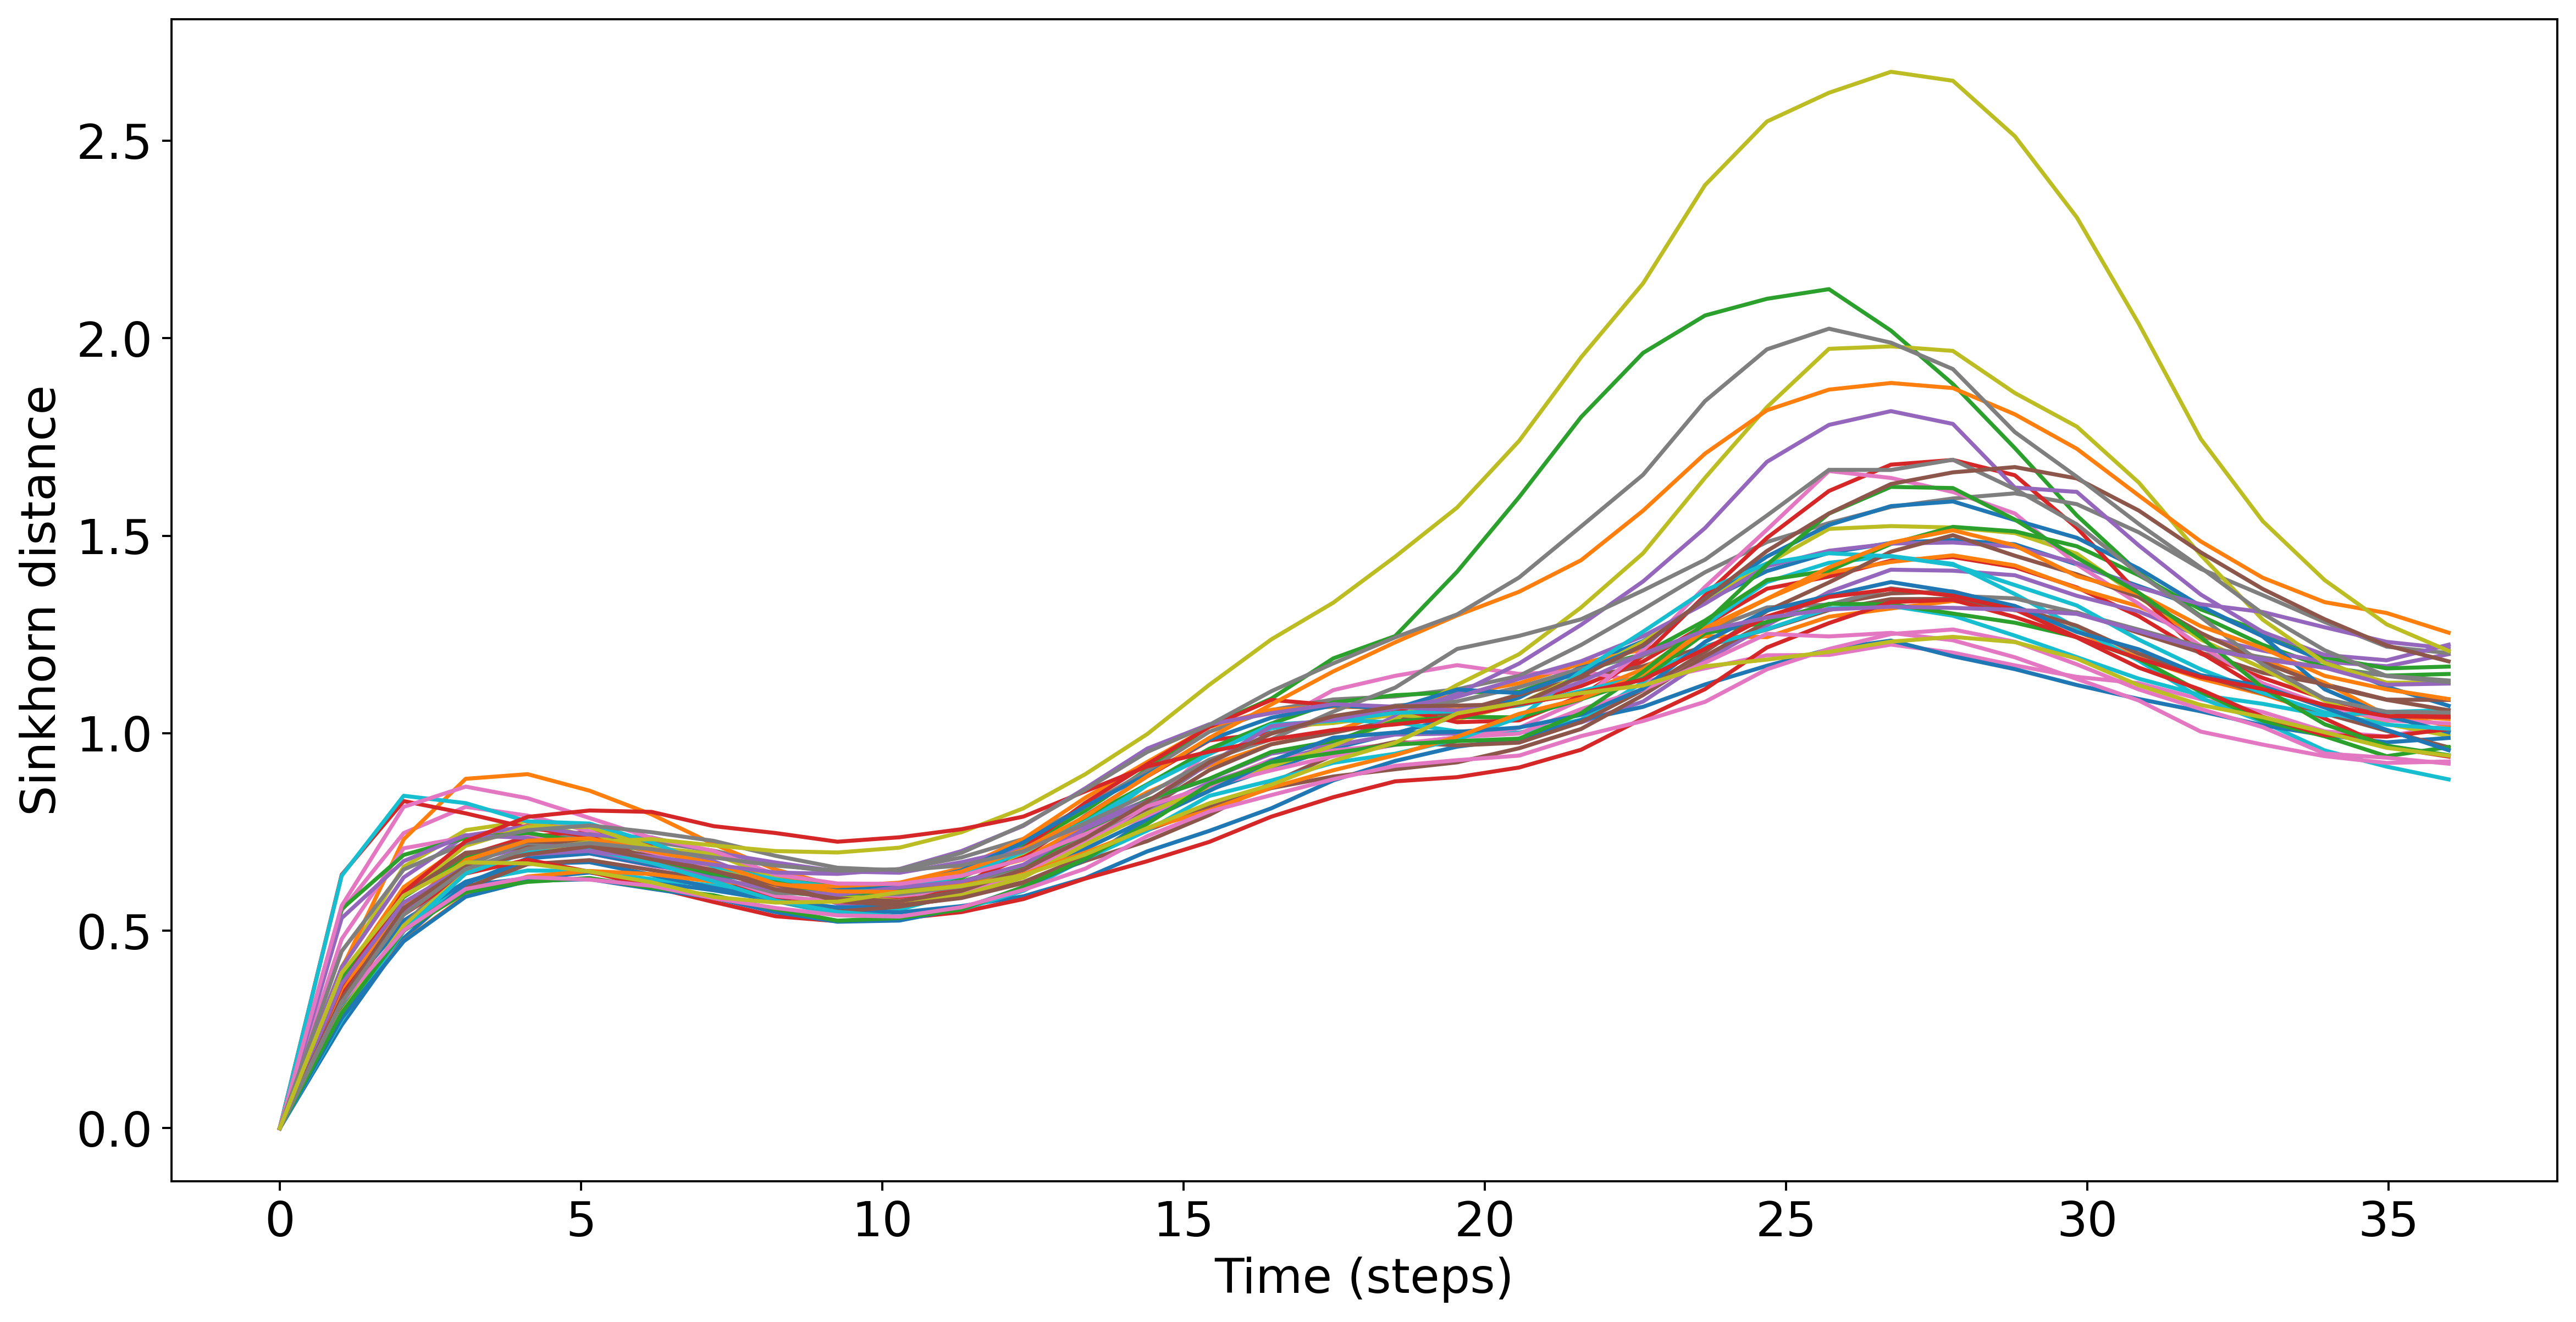

In [14]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(16,8),dpi=350)
for i in range(40):
    if i!=13:
        plt.plot(np.linspace(0,36,num=36),error[i])
        
plt.xlabel("Time (steps)")
plt.ylabel("Sinkhorn distance")

plt.savefig("./images/error.eps",format="eps")

In [15]:
time25 = [x[25] for x in error]
time25sort = sorted(time25)

for i in range(30,40):
    ind = time25.index(time25sort[i])
    print(ind)
    print("intensity",result[ind]["intensity"],result[ind]["step_size"],"prod:",result[ind]["intensity"]*result[ind]["step_size"])

36
intensity 140 0.03 prod: 4.2
14
intensity 140 0.03 prod: 4.2
17
intensity 160 0.05 prod: 8.0
28
intensity 100 0.01 prod: 1.0
15
intensity 170 0.04 prod: 6.8
22
intensity 170 0.02 prod: 3.4
19
intensity 160 0.05 prod: 8.0
38
intensity 190 0.02 prod: 3.8000000000000003
2
intensity 190 0.01 prod: 1.9000000000000001
29
intensity 130 0.02 prod: 2.6


In [16]:
tmp = [error[i][25] for i in range(40)]
tmp.index(max(tmp))

29

In [17]:
tmp.index(min(tmp))

13

In [18]:
### errors at 25th step for all the models
tmp

[1.4565690755844116,
 1.2948436737060547,
 2.124138832092285,
 1.3965357542037964,
 1.357591152191162,
 1.311862587928772,
 1.198172688484192,
 1.5319297313690186,
 1.5172812938690186,
 1.4313201904296875,
 1.2122951745986938,
 1.4063178300857544,
 1.41158127784729,
 0.7981076240539551,
 1.6132150888442993,
 1.7805122137069702,
 1.326366901397705,
 1.6637518405914307,
 1.3256447315216064,
 1.9730937480926514,
 1.3157215118408203,
 1.5271522998809814,
 1.869815707206726,
 1.3274836540222168,
 1.2786712646484375,
 1.4618546962738037,
 1.3815933465957642,
 1.244998812675476,
 1.6667007207870483,
 2.6213202476501465,
 1.4555031061172485,
 1.3479939699172974,
 1.419758677482605,
 1.5559486150741577,
 1.3447380065917969,
 1.3132047653198242,
 1.5562422275543213,
 1.2131173610687256,
 2.0240139961242676,
 1.2058418989181519]

In [19]:
sum(tmp)/40,tmp[29] ## meam error and the largest error

(1.4815701574087143, 2.6213202476501465)